<a href="https://colab.research.google.com/github/buzhangjiuzhou/DLfinal/blob/master/bert_AGnews_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
# 导入包
# transformer提供了一些训练好的模型，可以很方便的使用。
!pip install transformers
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.manifold import TSNE
import tqdm
# 使用分类的模型，增加了一个head用于分类。
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
% matplotlib inline

tf.__version__

'2.2.0'

In [116]:
# 导入现成的分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_113', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_113 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3076      
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0
_________________________________________________________________


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [118]:
# 数据链接，可以在 https://course.fast.ai/datasets 找到。
# agnews数据集，类别，标题，描述。
ag_url = 'https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz'

In [119]:
# 下载数据，并指定此时数据集的目录
ag_zip_file = tf.keras.utils.get_file(origin=ag_url,fname='ag_news_csv.tgz', extract=True)
base_dir = os.path.join(os.path.dirname(ag_zip_file), 'ag_news_csv')
os.listdir(base_dir)

['readme.txt', 'classes.txt', 'test.csv', 'train.csv']

In [120]:
# 读取数据
# 为了方便测试代码的时候少用几个数据,1000个数据可以让准确率上升到0.68
num = 1000
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), header=None)
# train = train.sample(n=num)
print(len(train))
print(train.head())
test = pd.read_csv(os.path.join(base_dir, 'test.csv'), header=None)
# test = test.sample(n=num)
print(len(test))
print(test.head())
f = open(os.path.join(base_dir, 'classes.txt'))
classes = f.readlines()
classes = [s.strip() for s in classes]
print(classes)

1000
       0  ...                                                  2
20091  2  ...  Professional baseball in Japan has truly come ...
42849  4  ...  Google Adwords Traffic Estimator Explained\\Go...
27695  1  ...  SINN Fein boss Gerry Adams plans to start tomo...
91711  2  ...  Computers Keep Oklahoma No. 2 in BCS, but Aubu...
32323  2  ...  Terry Francona deployed three Gold Glove winne...

[5 rows x 3 columns]
1000
      0  ...                                                  2
603   3  ...  After a month-long rally that repeatedly pushe...
4616  1  ...  The group led by wanted terrorist Abu Musab al...
7364  1  ...  Poland #39;s defense minister Jerzy Szmajdzins...
7397  2  ...  I appreciated Michael Vaughan #39;s honesty wh...
4950  3  ...  Software manufacturer Oracle Corp. said Monday...

[5 rows x 3 columns]
['World', 'Sports', 'Business', 'Sci/Tech']


In [121]:
# 预处理数据
# 按照上面的例子把数据集中的文本进行分词处理，并且得到对应的labels。
max_length = 256
max_length_temp = max_length - 2
train_ids = []
test_ids = []
for i in tqdm.notebook.trange(train.shape[0]):
  if len(train[2][train[2].index[i]]) > max_length_temp:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
for i in tqdm.notebook.trange(test.shape[0]):
  if len(test[2][test[2].index[i]]) > max_length_temp:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
train_labels = train[0].values - 1
test_labels = test[0].values - 1

In [122]:
# 把数据转成tensorflow张量
# train_ids是tf.Tensor组成得列表，所以用concat组合一下就行
train_ids = tf.concat(train_ids, 0)
# 把train_mask初始化为1，然后把train_ids等于0（PAD的部分）对应的值赋为0
train_mask = tf.ones(train_ids.shape)
train_mask = tf.where(tf.math.greater(train_ids, 0), train_mask, 0)
# labels本身是numpy数组，转为tf.Tensor
train_labels = tf.convert_to_tensor(train_labels)

# 测试集的处理同理test
test_ids = tf.concat(test_ids, 0)
test_mask = tf.ones(test_ids.shape)
test_mask = tf.where(tf.math.greater(test_ids, 0), test_mask, 0)
test_labels = tf.convert_to_tensor(test_labels)

In [123]:
print(train_ids[0])
print(train_mask[0])
print(train_labels[0])

tf.Tensor(
[  101  2658  3598  1999  2900  2038  5621  2272  1997  2287  1024  1996
  3842  2003 25919  2005  2049  2034  2412  2867  1001  4464  1025  4894
  1012  7576  2024  4854  2055  1037  3818  7660  2090  2048  4184  1010
  1996   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [124]:
# 训练参数
epochs = 1
batch_size = 16
validation_rate = 0.1

In [ ]:
# 模型放在这里
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4, output_hidden_states=True) # 分类类别数
model.summary()
model.config

In [ ]:
# 简单分类算法
model_compare = tf.keras.Sequential([
    tf.keras.layers.Embedding(30522, 768),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4)
])
model_compare.summary()

In [125]:
# 模型编译
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model_compare.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [126]:
# history是按照一个epoch记录一次，间隔太大了，所以手动重写一个基于batch的
class BatchCallback(tf.keras.callbacks.History):
  def __init__(self):
    self.batch = []
    self.history = {'loss':[], 'accuracy':[]}
  def on_train_batch_end(self, batch, logs=None):
    self.batch.append(batch)
    for k, v in logs.items():
      self.history[k].append(v)

In [127]:
# 模型训练
history = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

63/63 [==============================] - 100s 2s/step - loss: 0.7906 - accuracy: 0.7340


In [128]:
history_compare = model_compare.fit(
    x=[train_ids, train_mask],
    y=train_labels,
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1,
    callbacks=[BatchCallback()],
    shuffle=True
)

63/63 [==============================] - 31s 487ms/step - loss: 1.3934 - accuracy: 0.4960


In [129]:
# 模型测试
model.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=4, 
        verbose=1)

250/250 [==============================] - 39s 157ms/step - loss: 0.3899 - accuracy: 0.8840


[0.38992953300476074, 0.8840000033378601]

In [130]:
model_compare.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=4, 
        verbose=1)

250/250 [==============================] - 9s 34ms/step - loss: 1.3901 - accuracy: 0.2400


[1.3900822401046753, 0.23999999463558197]

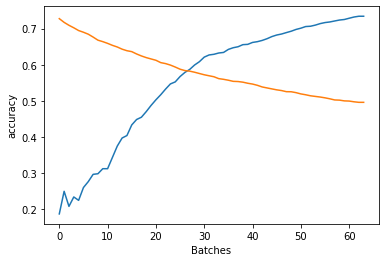

In [131]:
# 画图
def plot_graphs(history,history_compare, metric):
  plt.plot(history.history[metric])
  plt.plot(history_compare.history[metric])
  plt.xlabel("Batches")
  plt.ylabel(metric)
  plt.show()
plot_graphs(history, history_compare, 'accuracy')

In [134]:
index = None
for idx, layer in enumerate(model_compare.layers):
  print(idx, layer.name)

0 embedding_2
1 simple_rnn
2 dense_4
3 dense_5


In [155]:
# 得到RNN模型embedding的方法，get embedding层后，输入词的id，得到embeding
# 用index更好
embedding_compare = model_compare.get_layer(index=0)

In [200]:
# 得到每个类的embedding
avg_pool1 = tf.keras.layers.AveragePooling2D(pool_size=(max_length, 1))
embs_compare = embedding_compare(train_ids)
seq_embs_compare = tf.reshape(avg_pool1(tf.reshape(embs_compare,[-1,256,768,1])), [-1,768])
class_embedding_compare = np.zeros([4,768])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs_compare[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,768,1])
  class_embs = avg_pool2(class_embs)
  class_embedding_compare[i] = tf.reshape(class_embs, [768]).numpy()
print(class_embedding_compare)

[[-0.0232645   0.00372398  0.00151406 ... -0.0100215   0.00052512
   0.03462019]
 [-0.02319517  0.003597    0.00168267 ... -0.01013958  0.000431
   0.03422001]
 [-0.02252018  0.00381608  0.00163518 ... -0.00998482  0.00029146
   0.03348266]
 [-0.02298792  0.00354934  0.00163585 ... -0.00993546  0.0003401
   0.03429109]]


In [201]:
# 获得bert Embedding的方式，这里得到是整个embedding张量
embeddings = model.get_layer('bert').embeddings.word_embeddings

# 定义函数：通过词id 得到embedding
def get_embedding(input_ids, embeddings=embeddings):
  embeds = tf.gather(embeddings, input_ids)
  return embeds

In [202]:
# 得到每个类的embedding
embs = get_embedding(train_ids)
seq_embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,256,768,1])), [-1,768])
class_embedding = np.zeros([4,768])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,768,1])
  class_embs = avg_pool2(class_embs)
  class_embedding[i] = tf.reshape(class_embs, [768]).numpy()
print(class_embedding)

[[-0.01137918 -0.05449328 -0.02504636 ... -0.0191271  -0.03389259
  -0.0093737 ]
 [-0.01132686 -0.05435916 -0.02462213 ... -0.01935066 -0.03372006
  -0.0094386 ]
 [-0.0112552  -0.05452654 -0.0250123  ... -0.01901423 -0.03251801
  -0.0091024 ]
 [-0.01132575 -0.05443968 -0.02490911 ... -0.01861706 -0.0328639
  -0.00924618]]


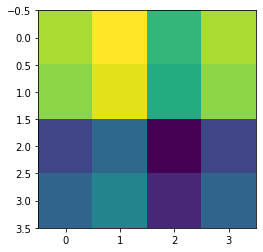

In [203]:
# 类表征的余弦相似性
res = sklearn.metrics.pairwise.cosine_similarity(class_embedding, class_embedding_compare)
plt.imshow(res)
plt.show()

In [231]:
# t-SNE分析,画图
def plot_scatter(emb, y_label, flag):
  t_sne_temp = TSNE(n_components=2).fit_transform(emb)
  y_label = [x + 10 * flag for x in y_label]
  plt.scatter(t_sne_temp[:,0], t_sne_temp[:,1], c=y_label)

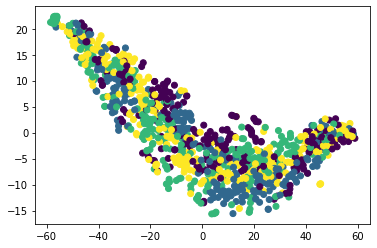

In [232]:
y_label = train_labels.numpy().tolist()
plot_scatter(seq_embs, y_label, 0)
plt.show()

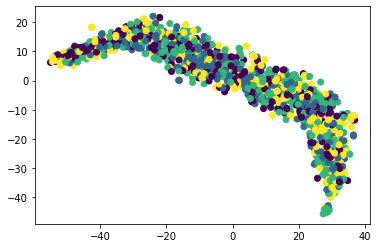

In [233]:
plot_scatter(seq_embs_compare, y_label, 1)
plt.show()